In [1]:
# 이번에는 캐글 titanic 데이터를 활용해서 생존자를 예측해보고자 한다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv('./train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [2]:
print(titanic_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [3]:
# 결측값 처리하기
## 결측치 제거후 EDA 과정 수행
titanic_df['Age'].fillna(titanic_df['Age'].mean(),inplace=True)
titanic_df['Cabin'].fillna('N',inplace=True)
titanic_df['Embarked'].fillna('N',inplace=True)

In [4]:
# 각 열별로 데이터 분포 살펴보기
print(titanic_df['Sex'].value_counts())
print(titanic_df['Cabin'].value_counts())
print(titanic_df['Embarked'].value_counts())

male      577
female    314
Name: Sex, dtype: int64
N              687
B96 B98          4
C23 C25 C27      4
G6               4
F2               3
              ... 
E49              1
A23              1
C30              1
D47              1
C128             1
Name: Cabin, Length: 148, dtype: int64
S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [5]:
# Cabin 클래스를 문자열 하나로 변경
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))
titanic_df['Cabin'].value_counts()

0    N
1    C
2    N
Name: Cabin, dtype: object


N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

In [6]:
# 그룹으로 묶어서 보기
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

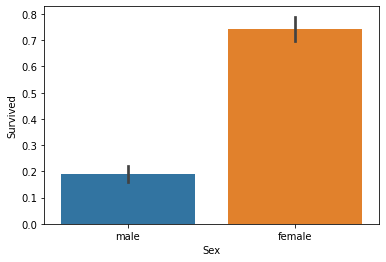

In [7]:
sns.barplot(x='Sex', y = 'Survived', data=titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

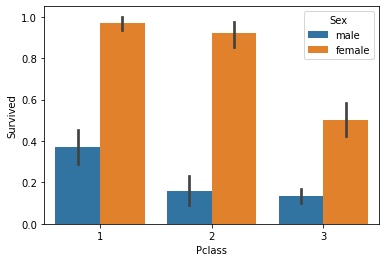

In [8]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

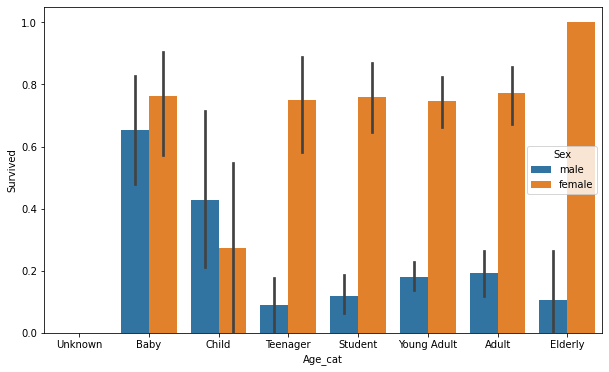

In [9]:
# 입력 age에 따라 구분값을 반환하는 함수 설정. DataFrame의 apply lambda식에 사용. 
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

# 막대그래프의 크기 figure를 더 크게 설정 
plt.figure(figsize=(10,6))

#X축의 값을 순차적으로 표시하기 위한 설정 
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category( ) 함수를 반환값으로 지정. 
# get_category(X)는 입력값으로 'Age' 컬럼값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y = 'Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

In [10]:
## 데이터 전처리 함수 설정
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [11]:
# 전처리
titanic_df = transform_features(titanic_df)

# 생존데이터를 종속변수로 지정
y = titanic_df['Survived']
X = titanic_df.drop('Survived',axis=1)

## 전처리를 먼저 수행해야 오류가 나지 않음.

# 데이터 스플릿
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.2, random_state=11)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
print(accuracy_score(y_test, dt_pred))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
print(accuracy_score(y_test, rf_pred))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print(accuracy_score(y_test, lr_pred))

##### 랜덤포레스트가 가장 정확함을 알 수 있다.

0.7877094972067039
0.8547486033519553
0.8491620111731844


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
## KFold 모형 사용
### cross_val_score를 사용
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X , y , cv=5)
for n, accuracy in enumerate(scores):
    print(n, accuracy)

print('Average is',np.mean(scores))

0 0.7430167597765364
1 0.7752808988764045
2 0.7921348314606742
3 0.7865168539325843
4 0.8426966292134831
Average is 0.7879291946519366


In [14]:
## 마지막으로 그리드서치 cv 이용
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid.fit(X_train , y_train)

print(grid.best_params_)
print(grid.best_score_)
best_dclf = grid.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredict = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredict)
print(accuracy)

###최고 정확도는 87.15 퍼센트이다.

{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.7991825076332119
0.8715083798882681
